In [1]:
import tensorflow as tf
from tensorflow.keras import Model

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   #if like me you do not have a lot of memory in your GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "" #then these two lines force keras to use your CPU
#import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization, Activation, Softmax
from tensorflow.keras.utils import to_categorical
#from tensorflow.keras.engine import InputLayer
#from tensorflow import keras 
import numpy as np
import matplotlib.pyplot as plt
import cv2
np.random.seed(66)


In [3]:
model2 = tf.keras.models.load_model('../3DCNN/tf_model/3dcnn_SPP16_2909')

In [4]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 10, 10, 6, 32)     7872      
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 10, 6, 32)     128       
_________________________________________________________________
activation (Activation)      (None, 10, 10, 6, 32)     0         
_________________________________________________________________
dropout (Dropout)            (None, 10, 10, 6, 32)     0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 5, 5, 3, 32)       0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 1, 1, 1, 64)       153664    
_________________________________________________________________
activation_1 (Activation)    (None, 1, 1, 1, 64)       0

In [5]:
def cnn_to_fcn (model):

    new_model = Sequential()

    input_layer = Input(shape=(None, None, None, 1), name="input_new")

    new_model.add(input_layer)
    
    i = 0    
    for layer in model.layers:

        if "SpatialPyramidPooling" in str(layer):
            flattened_ipt = True
            f_dim = layer.input_shape            

        elif "Dense" in str(layer):
            input_shape = layer.input_shape            
            output_dim =  layer.get_weights()[1].shape[0]            
            W,b = layer.get_weights()
            
            if flattened_ipt:
                shape = (f_dim[1],f_dim[2],f_dim[3],f_dim[4],output_dim)             
               
                W = W[:f_dim[4],:]
                
                new_W = W.reshape(shape)
                
                new_layer = Conv3D(output_dim,
                                          (f_dim[1],f_dim[2],f_dim[3]),
                                          strides=(1,1,1),
                                          activation=layer.activation,
                                          padding='valid',
                                          weights=[new_W,b],name="conv3d_mod1%s"%i)
                flattened_ipt = False
                i+=1

            else:                
                shape = (1,1,1,input_shape[1],output_dim)
                new_W = W.reshape(shape)
                new_layer = Conv3D(output_dim,
                                          (1,1,1),
                                          strides=(1,1,1),
                                          activation=layer.activation,
                                          padding='valid',
                                          weights=[new_W,b],name="conv3d_mod2%s"%i)
                i+=1


        else:
            new_layer = layer

        new_model.add(new_layer)

    return new_model

In [6]:
#model = tf.keras.applications.vgg16.VGG16()
new_model = cnn_to_fcn(model2)

new_model = change_model(model2, new_input_shape=(None,20,20,16,1))

In [7]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              multiple                  7872      
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
_________________________________________________________________
activation (Activation)      multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) multiple                  0         
_________________________________________________________________
conv3d_1 (Conv3D)            multiple                  153664    
_________________________________________________________________
activation_1 (Activation)    multiple                  0

for i in range(8):
    
    model2._layers.pop()
    print(i)


In [8]:
for l in model2.layers:
    print(l.name, l.trainable)

conv3d True
batch_normalization True
activation True
dropout True
max_pooling3d True
conv3d_1 True
activation_1 True
batch_normalization_1 True
spatial_pyramid_pooling True
dense True
dropout_1 True
activation_2 True
dense_1 True
activation_3 True
dropout_2 True
dense_2 True


In [9]:
from glob import glob
from nilearn import image
import scipy.io as sio 
import numpy as np

# caminho do banco de dados 
data_path = '/home/offsouza/otavio/Freela/cmb-3dcnn-data'

data_files = [filee for filee in sorted(glob(data_path + '/nii/*.nii'))][:10]
print(data_files)

/home/offsouza/miniconda3/envs/cuda/lib/python3.6/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


['/home/offsouza/otavio/Freela/cmb-3dcnn-data/nii/01.nii', '/home/offsouza/otavio/Freela/cmb-3dcnn-data/nii/02.nii', '/home/offsouza/otavio/Freela/cmb-3dcnn-data/nii/03.nii', '/home/offsouza/otavio/Freela/cmb-3dcnn-data/nii/04.nii', '/home/offsouza/otavio/Freela/cmb-3dcnn-data/nii/05.nii', '/home/offsouza/otavio/Freela/cmb-3dcnn-data/nii/06.nii', '/home/offsouza/otavio/Freela/cmb-3dcnn-data/nii/07.nii', '/home/offsouza/otavio/Freela/cmb-3dcnn-data/nii/08.nii', '/home/offsouza/otavio/Freela/cmb-3dcnn-data/nii/09.nii', '/home/offsouza/otavio/Freela/cmb-3dcnn-data/nii/10.nii']


In [10]:
#for files in data_files:
files = data_files[0]
img = image.smooth_img(files, fwhm=3).get_data()

/home/offsouza/miniconda3/envs/cuda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
img.shape

(512, 512, 150)

In [12]:
image = img.reshape(1,512,512,150,1)

In [13]:
#img = img[:,:512//3,:512//3,:150//3,:]
imgx = image[:,:180,:180,:78,:]


In [14]:
imgx.shape

(1, 180, 180, 78, 1)

In [15]:
a = new_model.predict(imgx)

In [16]:
a.shape

(1, 83, 83, 35, 2)

In [17]:
img = a.reshape(83,83,35,2)
img.shape

(83, 83, 35, 2)

In [18]:

colormap = 0

        
#imgx = total_maks[:,:,31,1]
imgx = img[:,60,:,1]
imgy = img[:,35,:,1]
imgz = img[:,:,10,1]

#imgx = img

imgx = (imgx * 255).round().astype(np.uint8)
imgy = (imgy * 255).round().astype(np.uint8)
imgz = (imgz * 255).round().astype(np.uint8)

if colormap:
        imgx = cv2.applyColorMap(imgx,5) #9 19 
        imgy = cv2.applyColorMap(imgy, 4)
        imgz = cv2.applyColorMap(imgz, 4)

In [19]:
imgx.shape

(83, 35)

[]

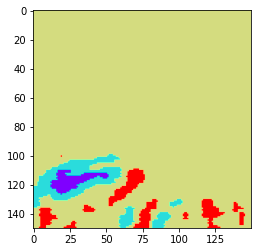

In [20]:
#arr = imgnp
imgxx = cv2.resize(imgx, (150,150))
plt.imshow(imgxx, cmap='rainbow')
#plt.colorbar()
#plt.plot(366, 120, 'bo')
plt.plot()

In [21]:
crop = [3,3,2]
images_shape = [512,512,150]
#img = img.reshape(1,512,512,150,1)

In [22]:
import numpy as np
crop = [3,3,2]

img = image.reshape(1,512,512,150,1)

data_slice_3 = ([0, 170, 341],[171, 341,512])
data_slice_2 = ([0, 75],[75, 150])

#(1, 78, 78, 30, 2)
out_slice_3 = ([0, 78, 156],[78, 156, 234])
out_slice_2 = ([0, 33],[33, 66])

total_mask = np.zeros((1,234,234,66,2))
#total_mask = np.zeros((1,512,512,150,1))

for slice2 in range(crop[2]): 
    for slice1 in range(crop[1]): 
        for slice0 in range(crop[0]): 
            
            
            img_crop = img[:, 
                           data_slice_3[0][slice0]:data_slice_3[1][slice0],
                           data_slice_3[0][slice1]:data_slice_3[1][slice1],
                           data_slice_2[0][slice2]:data_slice_2[1][slice2],:]
            
            print(img_crop.shape)
            
            score = new_model.predict(img_crop)
            
            total_mask[:, 
                       out_slice_3[0][slice0]:out_slice_3[1][slice0],
                       out_slice_3[0][slice1]:out_slice_3[1][slice1],
                       out_slice_2[0][slice2]:out_slice_2[1][slice2],:] = score
            
            #total_mask[:, 
            #               data_slice_3[0][slice0]:data_slice_3[1][slice0],
            #               data_slice_3[0][slice1]:data_slice_3[1][slice1],
            #               data_slice_2[0][slice2]:data_slice_2[1][slice2],:] = img_crop


print(total_mask.shape)
    #img = img[:, ]
        

(1, 171, 171, 75, 1)
(1, 171, 171, 75, 1)
(1, 171, 171, 75, 1)
(1, 171, 171, 75, 1)
(1, 171, 171, 75, 1)
(1, 171, 171, 75, 1)
(1, 171, 171, 75, 1)
(1, 171, 171, 75, 1)
(1, 171, 171, 75, 1)
(1, 171, 171, 75, 1)
(1, 171, 171, 75, 1)
(1, 171, 171, 75, 1)
(1, 171, 171, 75, 1)
(1, 171, 171, 75, 1)
(1, 171, 171, 75, 1)
(1, 171, 171, 75, 1)
(1, 171, 171, 75, 1)
(1, 171, 171, 75, 1)
(1, 234, 234, 66, 2)


In [23]:
total_maks = total_mask.reshape(234,234,66,2)

In [24]:
colormap = 0

        
imgx = total_maks[:,:,31,1]


imgx = (imgx * 255).round().astype(np.uint8)


if colormap:
        imgx = cv2.applyColorMap(imgx,5) #9 19 
        

[]

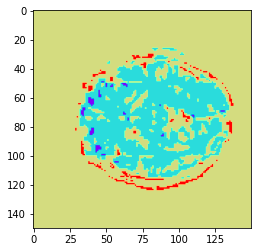

In [25]:
#arr = imgnp
imgxx = cv2.resize(imgx, (150,150))
plt.imshow(imgxx, cmap='rainbow')
#plt.colorbar()
#plt.plot(366, 120, 'bo')
plt.plot()